In [1]:
import jax.numpy as jnp
import jax.random as jr
from flowjax.flows import MaskedAutoregressiveFlow
from flowjax.train import fit_to_data
from flowjax.distributions import Normal
from flowjax.bijections import RationalQuadraticSpline
import matplotlib.pyplot as plt
from flowjax.tasks import two_moons
import numpy as np

In [2]:
nstar = 2000
ics_x = np.random.normal(loc=[8,0,0],scale=.05,size=(nstar,3))
ics_v = np.random.normal(loc=[0,.1,0],scale=.005,size=(nstar,3))
ics = jnp.array(np.hstack([ics_x,ics_v]))
t0 = jnp.array(np.zeros(len(ics))).T#.reshape(1,-1)


In [3]:
t0.shape, ics[:,:3].shape

((2000,), (2000, 3))

In [4]:
key, subkey = jr.split(jr.PRNGKey(0))
base_dist = Normal(jnp.zeros(3))
flow_x_t = MaskedAutoregressiveFlow(
    subkey,
    base_dist,
    RationalQuadraticSpline(knots=15, interval=40),
    cond_dim = 1
)

key, subkey = jr.split(key)
flow_x_t, losses = fit_to_data(
    key=subkey,
    dist=flow_x_t,
    x=ics[:,:3],
    condition=t0[:,None],
    learning_rate=5e-3,
    max_patience=10)

 35%|▎| 35/100 [00:14<00:26,  2.47it/s, train=-4.3344183, val=-4.4149218 (Max pa


In [5]:
samps = flow_x_t.sample(key=key,condition=t0[:,None],sample_shape=())

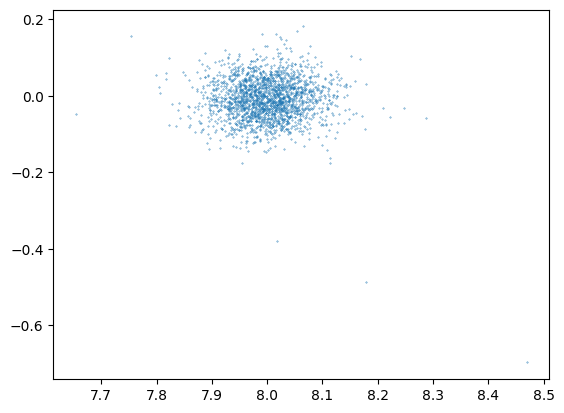

In [6]:
plt.scatter(samps[:,0],samps[:,1],s=.1)

In [7]:
key, subkey = jr.split(jr.PRNGKey(1))
base_dist = Normal(jnp.zeros(3))
flow_v_x_t = MaskedAutoregressiveFlow(
    subkey,
    base_dist,
    RationalQuadraticSpline(knots=30, interval=40),
    cond_dim = 4
)

key, subkey = jr.split(key)
flow_v_x_t, losses = fit_to_data(
    key=subkey,
    dist=flow_v_x_t,
    x=ics[:,3:],
    condition=jnp.hstack([ics[:,:3],t0[:,None]]),
    learning_rate=5e-3,
    max_patience=50)

100%|████████| 100/100 [00:31<00:00,  3.23it/s, train=-11.43757, val=-11.338518]


In [8]:
samps = flow_v_x_t.sample(key=key,condition=jnp.hstack([ics[:,:3],t0[:,None]]),sample_shape=())

(-0.3, 0.3)

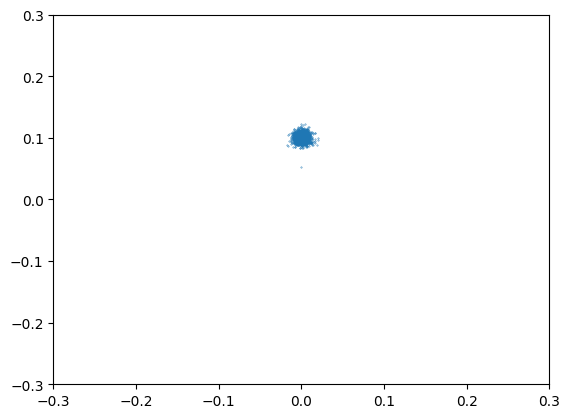

In [9]:
plt.scatter(samps[:,0],samps[:,1],s=.1)
plt.xlim(-0.3,.3)
plt.ylim(-0.3,.3)

In [160]:
import equinox as eqx
import jax
class NeuralNetwork(eqx.Module):
    layers: list
    extra_bias: jax.Array

    def __init__(self, key):
        key1, key2, key3 = jax.random.split(key, 3)
        # These contain trainable parameters.
        self.layers = [eqx.nn.Linear(4, 8, key=key1),
                       eqx.nn.Linear(8, 8, key=key2),
                       eqx.nn.Linear(8, 1, key=key3)]
        # This is also a trainable parameter.
        self.extra_bias = jax.numpy.ones(1)

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = jax.nn.tanh(layer(x))
        return self.layers[-1](x) + self.extra_bias

@jax.jit  # compile this function to make it run fast.
@jax.grad  # differentiate all floating-point arrays in `model`.
def loss(model, x, y):
    pred_y = jax.vmap(model)(x)  # vectorise the model over a batch of data
    return jax.numpy.mean((y - pred_y) ** 2)  # L2 loss

x_key, y_key, model_key = jax.random.split(jax.random.PRNGKey(0), 3)
# Example data
x = jax.random.normal(x_key, (100, 4))
y = jax.random.normal(y_key, (100, 4))
model = NeuralNetwork(model_key)


model_eval = lambda x: jax.vmap(model)(x).sum()

dphi_dinp = lambda x: jax.grad(model_eval)(x)
dphi_dinp_sum = lambda x: jax.grad(model_eval)(x).sum()
dphi2_dinp2 = lambda x: jax.grad(dphi_dinp_sum)(x)

#model_eval2 = dphi2_dinp2(x)
# Compute gradients
#grads = loss(model, x, y)

In [195]:
key = jax.random.PRNGKey(42)

In [196]:
import astropy
from astropy.constants import G
import astropy.units as u
G_val = G.to((u.kpc**3/(u.Msun*u.Myr**2))).value
@eqx.filter_value_and_grad
def loss_func(model,ii):
    key = jax.random.PRNGKey(ii)
    model_eval = lambda x: jax.vmap(model)(x).sum()
    dphi_dinp = lambda x: jax.grad(model_eval)(x)
    dphi_dinp_sum = lambda x: jax.grad(model_eval)(x).sum()
    dphi2_dinp2 = lambda x: jax.grad(dphi_dinp_sum)(x)

    samps = flow_x_t.sample(key=key,condition=t0[:,None],sample_shape=())
    density = jnp.exp(flow_x_t.log_prob(samps,t0[:,None]))*2000.
    laplacian = jnp.sum( dphi2_dinp2( jnp.hstack([samps,t0[:,None]]) )[:,:3] , axis = 1)
    return jnp.sum(jnp.square(laplacian - 4.0*jnp.pi*G_val*density)) + jnp.sum(jnp.square( jnp.minimum(laplacian, 0) ))

import optax  # https://github.com/deepmind/optax


In [201]:
# Important for efficiency whenever you use JAX: wrap everything into a single JIT
 # region.
@eqx.filter_jit
def make_step(model,opt_state, ii):
    loss, grads = loss_func(model, ii)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state
learning_rate = 1e-2
optim = optax.adam(learning_rate)
opt_state = optim.init(model)

steps = 200
for step in range(steps):
    loss, model, opt_state = make_step(model,opt_state, step)
    loss = loss.item()
    if step % 10 == 0:
        print(step)
    #print(f"step={step}, loss={loss}")

0
10
20
30


KeyboardInterrupt: 

In [202]:
model_eval = lambda x: jax.vmap(model)(x).sum()
dphi_dinp = lambda x: jax.grad(model_eval)(x)
dphi_dinp_sum = lambda x: jax.grad(model_eval)(x).sum()
dphi2_dinp2 = lambda x: jax.grad(dphi_dinp_sum)(x)

samps = flow_x_t.sample(key=key,condition=t0[:,None],sample_shape=())
density = jnp.exp(flow_x_t.log_prob(samps,t0[:,None]))*2000.
laplacian = jnp.sum( dphi2_dinp2( jnp.hstack([samps,t0[:,None]]) )[:,:3] , axis = 1)

In [203]:
x = jnp.linspace(-10,10,30)
X,Y = jnp.meshgrid(x,x)
inp_test = jnp.vstack([X.flatten(),Y.flatten(),jnp.zeros_like(X.flatten()), jnp.zeros_like(X.flatten())]).T
laplacian = jnp.sum( dphi2_dinp2(  inp_test  )[:,:3] , axis = 1)

density = jnp.exp(flow_x_t.log_prob(inp_test[:,:3], inp_test[:,-1][:,None]))*2000.


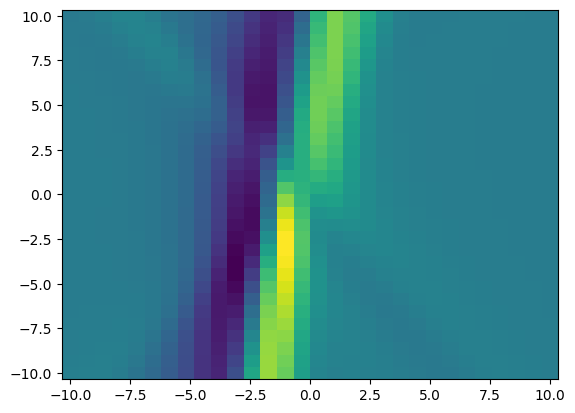

In [204]:
aa = laplacian.reshape(len(x),len(x))
plt.pcolormesh(X,Y,aa)

In [135]:
4*jnp.pi*G_val*density

Array([1.8537801e-05, 2.5734538e-05, 1.3212264e-06, ..., 4.9401220e-05,
       6.6881898e-06, 1.5206607e-06], dtype=float32)

In [85]:
# Important for efficiency whenever you use JAX: wrap everything into a single JIT
# region.
@eqx.filter_jit
def make_step(model, opt_state):
        loss, grads = compute_loss(model, x, y)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    optim = optax.adam(learning_rate)
    opt_state = optim.init(model)
    for step, (x, y) in zip(range(steps), iter_data):
        loss, model, opt_state = make_step(model, x, y, opt_state)
        loss = loss.item()
        print(f"step={step}, loss={loss}")

    pred_ys = jax.vmap(model)(xs)
    num_correct = jnp.sum((pred_ys > 0.5) == ys)
    final_accuracy = (num_correct / dataset_size).item()
    print(f"final_accuracy={final_accuracy}")

In [69]:
samps = flow_x_t.sample(key=key,condition=t0[:,None],sample_shape=())
density = jnp.exp(flow_x_t.log_prob(samps,t0[:,None]))*2000.
Laplacian = jnp.sum( dphi2_dinp2( jnp.hstack([samps,t0[:,None]]) )[:,:3] , axis = 1)
loss_func(density,Laplacian)

Array(0.00023171, dtype=float32)

In [67]:
second_derivs.shape

(2000,)

In [15]:
n_samples = 10000
rng = jr.PRNGKey(0)
x = two_moons(rng, n_samples)
#x = (x - x.mean(axis=0)) / x.std(axis=0)  # Standardize

In [16]:
key, subkey = jr.split(jr.PRNGKey(0))
base_dist = Normal(jnp.zeros(x.shape[1]))
flow = MaskedAutoregressiveFlow(
    subkey,
    base_dist,
    RationalQuadraticSpline(knots=8, interval=4),
)


In [17]:
key, subkey = jr.split(key)
flow, losses = fit_to_data(subkey, flow, x, learning_rate=1e-3)

 34%|▎| 34/100 [00:26<00:50,  1.30it/s, train=2.4324656, val=2.4858453 (Max pati


In [19]:
five_points = jnp.ones((5, 2))
flow.log_prob(five_points)

Array([-2.4572847, -2.4572847, -2.4572847, -2.4572847, -2.4572847],      dtype=float32)

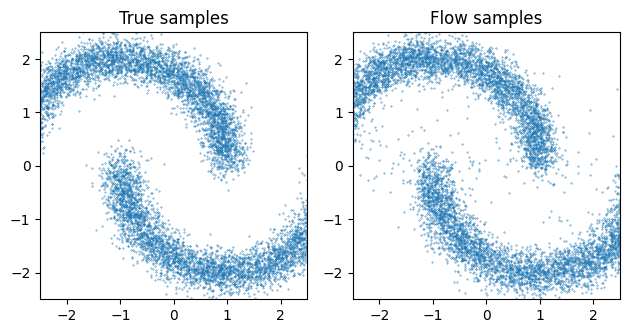

In [20]:
key, subkey = jr.split(key)
x_samples = flow.sample(subkey, (n_samples,))

fig, axs = plt.subplots(ncols=2)

axs[0].scatter(x[:, 0], x[:, 1], s=0.1)
axs[0].set_title("True samples")

axs[1].scatter(x_samples[:, 0], x_samples[:, 1], s=0.1)
axs[1].set_title("Flow samples")

lims = (-2.5, 2.5)
for ax in axs:
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect("equal")

plt.tight_layout()
plt.show()